### Importing libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from datasets import load_dataset

### Importing the dataset I will use to train my network

In [6]:
dataset = load_dataset("keremberke/license-plate-object-detection", "full")

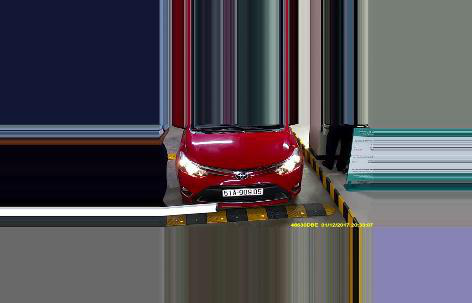

In [10]:
dataset['train']['image'][3] # showing example image